In [1]:
import spectral_entropy
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from rdkit import Chem
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
import torch
import torch.nn.functional as F
import dreams.utils.mols as mu
import matplotlib.pyplot as plt
import dreams.utils.plots as plots
from dreams.definitions import *
plots.init_plotting()
%load_ext autoreload
%autoreload 2

In [7]:
print(len(spectral_entropy.methods_name), 'metrics implemented in "spectral_entropy" package.')
spectral_entropy.methods_name

44 metrics implemented in "spectral_entropy" package.


{'entropy': 'Entropy distance',
 'unweighted_entropy': 'Unweighted entropy distance',
 'euclidean': 'Euclidean distance',
 'manhattan': 'Manhattan distance',
 'chebyshev': 'Chebyshev distance',
 'squared_euclidean': 'Squared Euclidean distance',
 'fidelity': 'Fidelity distance',
 'matusita': 'Matusita distance',
 'squared_chord': 'Squared-chord distance',
 'bhattacharya_1': 'Bhattacharya 1 distance',
 'bhattacharya_2': 'Bhattacharya 2 distance',
 'harmonic_mean': 'Harmonic mean distance',
 'probabilistic_symmetric_chi_squared': 'Probabilistic symmetric χ2 distance',
 'ruzicka': 'Ruzicka distance',
 'roberts': 'Roberts distance',
 'intersection': 'Intersection distance',
 'motyka': 'Motyka distance',
 'canberra': 'Canberra distance',
 'baroni_urbani_buser': 'Baroni-Urbani-Buser distance',
 'penrose_size': 'Penrose size distance',
 'mean_character': 'Mean character distance',
 'lorentzian': 'Lorentzian distance',
 'penrose_shape': 'Penrose shape distance',
 'clark': 'Clark distance',
 'h

In [5]:
# Filter NIST20 to only [M+H]+ adducts
df = pd.read_pickle(NIST20 / 'nist20_clean_A.pkl')
print(len(df))
df = df[df['PRECURSOR TYPE'] == '[M+H]+']
print(len(df))
df = df.reset_index(drop=True).reset_index()
df['EXACT MASS'] = df['EXACT MASS'].astype(float)
df['SMILES'] = df['ROMol'].progress_apply(Chem.MolToSmiles)

# Compute first blocks of InChI keys
df['inchi14'] = df['INCHIKEY'].apply(lambda k: k.split('-')[0])

# Retrieve candidates with similar precursor m/z values
pandarallel.initialize(nb_workers=4, progress_bar=True, use_memory_fs=False)
def get_candidate_idx(row, ppm_delta=10):
    mz_delta = row['EXACT MASS'] * 1e-6 * ppm_delta
    return df['EXACT MASS'][
        (df['EXACT MASS'] >= row['EXACT MASS'] - mz_delta) & \
        (df['EXACT MASS'] <= row['EXACT MASS'] + mz_delta) & \
        (df['index'] != row['index'])
        ].index.values
df['candidates'] = df.parallel_apply(get_candidate_idx, axis=1)

# Store
# df.to_pickle(NIST20 / 'nist20_clean_spec_entropy_[M+H]+_retrieval.pkl')
# df = pd.read_pickle(NIST20 / 'nist20_clean_spec_entropy_[M+H]+_retrieval.pkl')
df

355219
153236


100%|██████████| 153236/153236 [00:04<00:00, 30993.26it/s]


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,index,NAME,NOTES,PRECURSOR TYPE,SPECTRUM TYPE,PRECURSOR M/Z,INSTRUMENT TYPE,INSTRUMENT,SAMPLE INLET,IONIZATION,...,#C,#O,#N,#S,#P,#Cl,#F,SMILES,inchi14,candidates
0,0,"1,2-Dioleoyl-sn-glycero-3-phospho-(1'-myo-inos...",Water/isopropanol/Formic acid; added_Vial_ID=6039,[M+H]+,MS2,863.5644,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,45,13,0,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...,LALGUHSIWLNTNW,[]
1,1,"1,2-dioleoyl-sn-glycero-3-phosphatidylcholine",Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,786.6007,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,44,8,1,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,SNKAWJBJQDLSFF,"[2, 16495, 16496, 16497, 16498, 16499, 16500, ..."
2,2,"1,2-dioleoyl-sn-glycero-3-phosphatidylcholine",Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,786.6007,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,44,8,1,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,SNKAWJBJQDLSFF,"[1, 16495, 16496, 16497, 16498, 16499, 16500, ..."
3,3,"1,2-Dioleoyl-sn-glycero-3-phosphoethanolamine",Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,744.5538,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,41,8,1,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,MWRBNPKJOOWZPW,"[16535, 16536, 16537, 16538, 16539, 16540, 165..."
4,4,1-Eicosatrienoyl-sn-glycero-3-phosphoethanolamine,Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,504.3085,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,...,25,7,1,0,1,0,0,CCCCC/C=C\C/C=C\C/C=C\CCCCCCC(=O)OCC(O)CO[P@SP...,RNWSKZCVPICGIX,"[5, 6, 7, 8, 9, 10, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153231,153231,(3'-sulfo)Gal.beta.-Cer(d18:1/22:0),micromol/L in water/acetonitrile/formic acid (...,[M+H]+,MS2,864.6229,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,...,46,11,1,1,0,0,0,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,UAKYQMHTPLVMJD,"[153226, 153227, 153228, 153229, 153230, 15323..."
153232,153232,(3'-sulfo)Gal.beta.-Cer(d18:1/22:0),micromol/L in water/acetonitrile/formic acid (...,[M+H]+,MS2,864.6229,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,...,46,11,1,1,0,0,0,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,UAKYQMHTPLVMJD,"[153226, 153227, 153228, 153229, 153230, 15323..."
153233,153233,(3'-sulfo)Gal.beta.-Cer(d18:1/22:0),micromol/L in water/acetonitrile/formic acid (...,[M+H]+,MS2,864.6229,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,...,46,11,1,1,0,0,0,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,UAKYQMHTPLVMJD,"[153226, 153227, 153228, 153229, 153230, 15323..."
153234,153234,(3'-sulfo)Gal.beta.-Cer(d18:1/22:0),micromol/L in water/acetonitrile/formic acid (...,[M+H]+,MS2,864.6229,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,...,46,11,1,1,0,0,0,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,UAKYQMHTPLVMJD,"[153226, 153227, 153228, 153229, 153230, 15323..."


Num. of pairs: 5269376


Text(0.5, 0, 'Num. candidates')

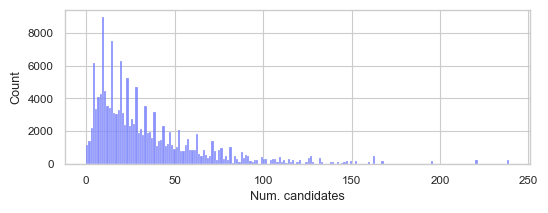

In [6]:
# Fig. 2. https://static-content.springer.com/esm/art%3A10.1038%2Fs41592-021-01331-z/MediaObjects/41592_2021_1331_MOESM1_ESM.pdf
print('Num. of pairs:', len(df[['candidates']].explode('candidates')))
sns.histplot(df['candidates'].apply(len))
plt.xlabel('Num. candidates')

In [7]:
# Get indices of all pairs, for which similarities have to be computed
idx_pairs = df[['candidates', 'index']].explode('candidates').dropna().values.astype(int)
idx_pairs.sort(axis=1)
idx_pairs = np.unique(idx_pairs, axis=0)
df_res = pd.DataFrame(idx_pairs, columns=['i', 'j'])

# Compute labels
pandarallel.initialize(nb_workers=4, progress_bar=True, use_memory_fs=False)
df_res['inchi14 label'] = df_res.parallel_apply(lambda row: df['inchi14'].iloc[row['i']] == df['inchi14'].iloc[row['j']], axis=1).astype(int)
df_res

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,i,j,inchi14 label
0,1,2,1
1,1,16495,0
2,1,16496,0
3,1,16497,0
4,1,16498,0
...,...,...,...
2634499,153232,153234,1
2634500,153232,153235,1
2634501,153233,153234,1
2634502,153233,153235,1


0

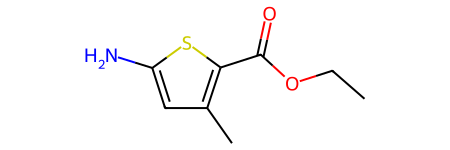

185.051049

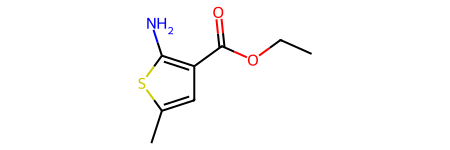

185.051049

1

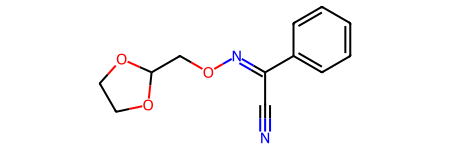

232.084792

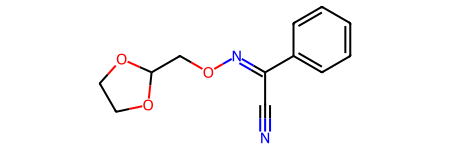

232.084792

In [8]:
for i in df_res.index.to_series().sample(2, random_state=4):
    display(df_res.iloc[i]['inchi14 label'])
    display(df.iloc[df_res.iloc[i]['i']]['ROMol'])
    display(df.iloc[df_res.iloc[i]['i']]['EXACT MASS'])
    display(df.iloc[df_res.iloc[i]['j']]['ROMol'])
    display(df.iloc[df_res.iloc[i]['j']]['EXACT MASS'])

In [9]:
df_res['inchi14 label'].value_counts()

0    1929857
1     704647
Name: inchi14 label, dtype: int64

In [10]:
non_method_cols = []
for c in ['SMILES', 'PARSED PEAKS', 'PRECURSOR M/Z']:#, 'matchms spectrum']:
    for k in ['i', 'j']:
        col = f'{c} {k}'
        df_res[col] = df_res[k].apply(lambda i: df[c].iloc[i])
        non_method_cols.append(col)
non_method_cols.extend(['i', 'j', 'inchi14 label'])
df_res

,i,j,inchi14 label,SMILES i,SMILES j,PARSED PEAKS i,PARSED PEAKS j,PRECURSOR M/Z i,PRECURSOR M/Z j
0,1,2,1,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[86.1, 125.0, 184.07, 185.07, 0.0, 0.0, 0.0, ...",786.6007,786.6007
1,1,16495,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCC...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[86.0962, 184.0737, 185.077, 786.6026, 787.60...",786.6007,786.6007
2,1,16496,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCC...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[63.8199, 71.0729, 80.9737, 81.0699, 86.0964,...",786.6007,786.6007
3,1,16497,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCC...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[71.0729, 80.9735, 81.0698, 85.0649, 86.0965,...",786.6007,786.6007
4,1,16498,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCC...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[56.1016, 58.5763, 70.0652, 71.0729, 80.9735,...",786.6007,786.6007
...,...,...,...,...,...,...,...,...,...
2634499,153232,153234,1,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,"[[236.236, 252.2672, 253.2704, 256.263, 262.25...","[[254.2836, 264.2672, 265.2708, 309.2098, 311....",864.6229,864.6229
2634500,153232,153235,1,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,"[[236.236, 252.2672, 253.2704, 256.263, 262.25...","[[311.2249, 364.2511, 365.2552, 382.2614, 383....",864.6229,864.6229
2634501,153233,153234,1,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,"[[184.0253, 236.2368, 252.2678, 254.2838, 262....","[[254.2836, 264.2672, 265.2708, 309.2098, 311....",864.6229,864.6229
2634502,153233,153235,1,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,"[[184.0253, 236.2368, 252.2678, 254.2838, 262....","[[311.2249, 364.2511, 365.2552, 382.2614, 383....",864.6229,864.6229


In [11]:
# from dreams.utils.dreams import get_dreams_embeddings
# model_pth = PRETRAINED / 'CtDh6OHlhA_epoch=0-step=2500.ckpt'
# dreams_embs_i = get_dreams_embeddings(model=model_pth, df_spectra=df_res, spec_col='PARSED PEAKS i', prec_mz_col='PRECURSOR M/Z i')
# dreams_embs_j = get_dreams_embeddings(model=model_pth, df_spectra=df_res, spec_col='PARSED PEAKS j', prec_mz_col='PRECURSOR M/Z j')
# # dreams_embs_i = torch.load('data/spec_retrieval_50k_embs_i.pt', map_location=torch.device('cpu'))
# # dreams_embs_j = torch.load('data/spec_retrieval_50k_embs_j.pt', map_location=torch.device('cpu'))
# dreams_embs_i.shape

Computing DreaMS:   6%|▌         | 39/625 [00:41<10:28,  1.07s/it]

KeyboardInterrupt



In [ ]:
# df_res['DreaMS'] = df_res.reset_index().apply(
#     lambda row: F.cosine_similarity(dreams_embs_i[row['index']], dreams_embs_j[row['index']], dim=0).item()
# , axis='columns')

In [11]:
from tqdm import tqdm
tqdm.pandas()

def compute_scores(row):
    return tuple(
        list(spectral_entropy.all_similarity(df['PARSED PEAKS'].iloc[int(row['i'])].T, df['PARSED PEAKS'].iloc[int(row['j'])].T, ms2_da=0.05).values())
    )

pandarallel.initialize(nb_workers=4, progress_bar=True, use_memory_fs=False)
df_res[list(spectral_entropy.methods_name.values())] = df_res.parallel_apply(
    compute_scores, axis='columns', result_type='expand'
)

df_res

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,i,j,inchi14 label,SMILES i,SMILES j,PARSED PEAKS i,PARSED PEAKS j,PRECURSOR M/Z i,PRECURSOR M/Z j,Entropy distance,...,Wave Hedges distance,Jaccard distance,Dice distance,Inner product distance,Divergence distance,"Avg (L1, L∞) distance",Vicis-Symmetric χ2 3 distance,MSforID distance version 1,MSforID distance,Weighted dot product distance
0,1,2,1,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[86.1, 125.0, 184.07, 185.07, 0.0, 0.0, 0.0, ...",786.6007,786.6007,4.395711e-01,...,0.119974,0.648754,0.786963,0.419510,0.066308,0.126873,6.166220e-01,0.048280,0.044712,0.014652
1,1,16495,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCC...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[86.0962, 184.0737, 185.077, 786.6026, 787.60...",786.6007,786.6007,7.670993e-01,...,0.149745,0.606844,0.755324,0.280200,0.091993,0.264575,7.065804e-01,0.774474,0.421098,0.813855
2,1,16496,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCC...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[63.8199, 71.0729, 80.9737, 81.0699, 86.0964,...",786.6007,786.6007,4.408216e-01,...,0.097257,0.591079,0.742992,0.302201,0.052550,0.146612,5.645764e-01,0.290316,0.042674,0.014576
3,1,16497,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCC...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[71.0729, 80.9735, 81.0698, 85.0649, 86.0965,...",786.6007,786.6007,4.067883e-01,...,0.097784,0.446116,0.616985,0.222454,0.052560,0.007754,4.818188e-01,0.279858,0.029517,0.014454
4,1,16498,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCC...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...","[[56.1016, 58.5763, 70.0652, 71.0729, 80.9735,...",786.6007,786.6007,3.228931e-01,...,0.084421,0.175180,0.298133,0.101965,0.046594,0.000000,2.739613e-01,0.240827,0.028912,0.013801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634499,153232,153234,1,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,"[[236.236, 252.2672, 253.2704, 256.263, 262.25...","[[254.2836, 264.2672, 265.2708, 309.2098, 311....",864.6229,864.6229,4.810035e-01,...,0.040867,0.852275,0.920247,0.363860,0.021244,0.363073,6.654847e-01,0.107691,0.305966,0.097547
2634500,153232,153235,1,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,"[[236.236, 252.2672, 253.2704, 256.263, 262.25...","[[311.2249, 364.2511, 365.2552, 382.2614, 383....",864.6229,864.6229,1.787746e-01,...,0.030845,0.005880,0.011691,0.002891,0.016690,0.000000,9.950769e-02,0.824152,0.000000,0.200659
2634501,153233,153234,1,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,"[[184.0253, 236.2368, 252.2678, 254.2838, 262....","[[254.2836, 264.2672, 265.2708, 309.2098, 311....",864.6229,864.6229,8.560985e-01,...,0.119805,0.989327,0.994635,0.501869,0.074828,0.839553,9.474922e-01,0.962711,0.778641,0.964314
2634502,153233,153235,1,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...,"[[184.0253, 236.2368, 252.2678, 254.2838, 262....","[[311.2249, 364.2511, 365.2552, 382.2614, 383....",864.6229,864.6229,1.692348e-07,...,0.029412,0.000000,0.000000,0.000000,0.014925,0.000000,5.960464e-08,0.000000,0.000000,0.000000


In [2]:
# df_res = df_res.sample(n=1_000_000, random_state=1)
df_res = pd.read_pickle('data/spec_retrieval_1M_dreams_preds_60peaks_epoch=0-step=2500.pkl')

In [3]:
df_res2 = pd.read_pickle('data/spec_retrieval_1M_dreams_preds_fixed.pkl')

In [4]:
df_res['DreaMS'] = df_res2['DreaMS']

In [5]:
disjoin_inchi14s = pd.read_pickle(EXPERIMENTS_DIR / 'spec_sim/data/nist_inchi14s_disjoint_from_mona_contrastive.pkl')
disjoin_inchi14s

0        LALGUHSIWLNTNW
1        SNKAWJBJQDLSFF
2        MWRBNPKJOOWZPW
3        RNWSKZCVPICGIX
4        NVWYLRLKCCCUBZ
              ...      
21750    QKHHCXOSPQAQQI
21751    HUKQFKKFOGVZGH
21752    QRNWLIBAWZHZNY
21753    PKLSFJOTJYLMTM
21754    UAKYQMHTPLVMJD
Length: 21755, dtype: object

In [6]:
pandarallel.initialize(nb_workers=4, progress_bar=True, use_memory_fs=False)
df_res['inchi14 i'] = df_res['SMILES i'].parallel_apply(mu.smiles_to_inchi14)
df_res['inchi14 j'] = df_res['SMILES j'].parallel_apply(mu.smiles_to_inchi14)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
df_res = df_res[df_res['inchi14 i'].isin(disjoin_inchi14s) & df_res['inchi14 j'].isin(disjoin_inchi14s)]
df_res

,i,j,inchi14 label,SMILES i,SMILES j,PARSED PEAKS i,PARSED PEAKS j,PRECURSOR M/Z i,PRECURSOR M/Z j,Entropy distance,...,Divergence distance,"Avg (L1, L∞) distance",Vicis-Symmetric χ2 3 distance,MSforID distance version 1,MSforID distance,Weighted dot product distance,DreaMS (zero-shot),DreaMS,inchi14 i,inchi14 j
1,5538,39525,0,COc1ccc2c3c([nH]c2c1)C(C)=NCC3,COc1ccc2[nH]c3c(c2c1)CCN=C3C,"[[42.03, 68.05, 77.04, 115.05, 117.06, 129.06,...","[[53.6604, 68.0495, 75.9552, 131.0739, 155.074...",215.1179,215.1179,0.687919,...,0.018792,0.190929,0.613376,0.976035,0.485200,0.728753,0.850552,0.688087,RERZNCLIYCABFS,HMBHRMFLDKKSCT
3,118393,118394,1,O=C1Nc2ncc(Br)cc2C1=O,O=C1Nc2ncc(Br)cc2C1=O,"[[67.0415, 83.0365, 91.029, 92.0368, 92.9333, ...","[[64.0181, 65.0259, 67.0416, 83.0365, 91.029, ...",226.9451,226.9451,0.922360,...,0.060906,0.559200,0.874094,0.974802,0.836247,0.966477,0.935215,0.925110,RAIHKZDTYPKUHB,RAIHKZDTYPKUHB
4,34404,142483,0,CNC(C)C(=O)c1ccccc1C,NC[C@H]1CC[C@@H](c2ccccc2)O1,"[[58.0654, 91.0543, 93.0701, 117.0703, 119.049...","[[50.015, 51.0229, 51.0243, 52.0307, 55.0178, ...",178.1226,178.1226,0.059908,...,0.018984,0.000000,0.009933,0.005511,0.000000,0.005389,0.591699,0.299202,PRGXFAWAMOFULD,IAIACGGIZWXQIK
5,33576,60316,0,Cc1ccc(CC(C)N)cc1,CC(C)(C)c1cccc(N)c1,"[[65.0385, 77.0384, 79.0541, 91.0542, 93.0698,...","[[50.015, 51.0228, 53.0384, 55.054, 57.0697, 6...",150.1277,150.1277,0.639014,...,0.024874,0.000000,0.358009,0.928688,0.145648,0.496961,0.906771,0.590164,ZDHZDWSHLNBTEB,DPKTVUKEPNBABS
6,768,3283,0,C=CC1(C)CCC(C(C)(C)O)O1,CCCCC/C=C/C(=O)OCC,"[[41.04, 43.02, 43.05, 53.04, 55.05, 57.07, 59...","[[55.02, 55.06, 73.03, 83.09, 97.1, 125.1, 143...",171.1380,171.1380,0.126200,...,0.024241,0.000000,0.045938,0.352933,0.000000,0.005807,0.844906,0.355538,BRHDDEIRQPDPMG,AISZSTYLOVXFII
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999992,71409,91734,0,CC(=O)c1c[nH]c2ccc([N+](=O)[O-])cc12,CC(=O)Nc1ccc2c(c1)C(=O)NC2=O,"[[117.0567, 130.0645, 133.0516, 143.0358, 144....","[[92.0495, 120.0443, 121.0283, 121.0476, 145.0...",205.0608,205.0608,0.158762,...,0.032835,0.000000,0.078072,0.145834,0.000000,0.107307,0.929643,0.587297,MKWCZAGQLZTPIE,PAIDIYNSOHDQLE
999994,125788,148942,0,Nc1cccc(F)c1O,COc1ccnc(F)c1,"[[51.0229, 52.0307, 53.0385, 54.0338, 55.0178,...","[[51.0231, 52.0182, 53.0023, 53.0387, 55.0179,...",128.0506,128.0506,0.343594,...,0.019291,0.000000,0.305087,0.793644,0.158752,0.046707,0.867369,0.329112,MDIAVSZFIQWYST,ILAHVONGWYINEB
999997,92686,93097,0,COC(=O)CCC(=O)Nc1ccccc1Cl,CCOC(=O)CNC(=O)c1ccccc1Cl,"[[51.0229, 53.0022, 55.0179, 59.0128, 59.0491,...","[[51.0231, 53.0023, 65.0387, 74.0152, 75.0231,...",242.0578,242.0578,0.304526,...,0.018140,0.000000,0.168495,0.803618,0.000000,0.389760,0.748477,0.496142,JAXOGQBKZQFMEP,QNFWTLCXVVBTGD
999998,7870,64042,0,NC(CO)C(=O)NC(CC(=O)O)C(=O)O,NC(CC(=O)O)C(=O)NC(CO)C(=O)O,"[[42.03, 44.05, 56.05, 60.04, 61.05, 70.03, 74...","[[60.0443, 70.0286, 74.0235, 83.0127, 84.0443,...",221.0768,221.0768,0.375592,...,0.012131,0.000000,0.317778,0.508996,0.016144,0.042410,0.849627,0.699390,VBKBDLMWICBSCY,DWBZEJHQQIURML


In [8]:
df_res = df_res.drop(columns=['inchi14 i', 'inchi14 j'])

In [9]:
non_method_cols = [c for c in df_res.columns if c not in list(spectral_entropy.methods_name.values()) + ['DreaMS', 'DreaMS (zero-shot)']]

100%|██████████| 45/45 [00:06<00:00,  6.99it/s]


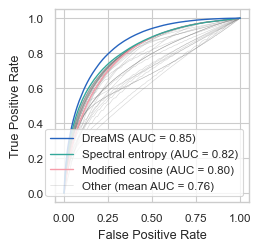

In [67]:
from sklearn import metrics
from tqdm import tqdm
from statistics import mean
from dreams.utils.plots import get_nature_hex_colors, save_fig

colors = get_nature_hex_colors()
plots.init_plotting(figsize=(3.2, 3.2))
# plots.init_plotting(figsize=(2.5, 2.5))

methods_renaming = {
    'Entropy distance': 'Spectral entropy',
    'Cosine distance': 'Modified cosine',
    'DreaMS': 'DreaMS',
    'DreaMS (zero-shot)': 'DreaMS (zero-shot)'
}

def zorder(col):
    if col not in special_metrics:
        return 1
    elif col == 'DreaMS':
        return 5
    elif col == 'Entropy distance':
        return 4
    elif col == 'DreaMS (zero-shot)':
        return 3
    else:
        return 2

df_res = df_res[['DreaMS', 'Entropy distance', 'Cosine distance'] + [c for c in df_res.columns if c not in methods_renaming.keys()]]

metric_names = df_res.drop(columns=non_method_cols).columns.tolist()
special_metrics = ['Entropy distance', 'Cosine distance', 'DreaMS', 'DreaMS (zero-shot)']
non_special_metrics = [m for m in metric_names if m not in special_metrics]
label_col = 'inchi14 label'
non_special_aucs = []

special_plot_i = 0
for curve_func in [metrics.roc_curve]:#, metrics.precision_recall_curve]:
    for col in tqdm(metric_names):
        fpr, tpr, thresholds = curve_func(df_res[label_col], df_res[col])
        auc = metrics.auc(fpr, tpr)
        if col in special_metrics:
            plt.plot(fpr, tpr, label=f'{methods_renaming[col]} (AUC = {auc:.2f})' if curve_func == metrics.roc_curve else col, linewidth=1, zorder=zorder(col), color=colors[special_plot_i])
            special_plot_i += 1
        else:
            non_special_aucs.append(auc)
            plt.plot(
                fpr, tpr, color='grey', alpha=0.35, linewidth=0.4,
                label=(f'Other (mean AUC = {mean(non_special_aucs):.2f})' if curve_func == metrics.roc_curve else 'Other metrics') if col == non_special_metrics[-1] else None, zorder=zorder(col)
            )
        # break
    if curve_func == metrics.roc_curve:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    else:
        plt.xlabel('Recall')
        plt.ylabel('Precision')
    plt.legend(markerscale=0.1, loc='lower right')#, bbox_to_anchor=(-0.02, 0.0))
    save_fig(f'spec_retrieval_roc.svg')
    plt.show()

100%|██████████| 46/46 [00:06<00:00,  6.66it/s]


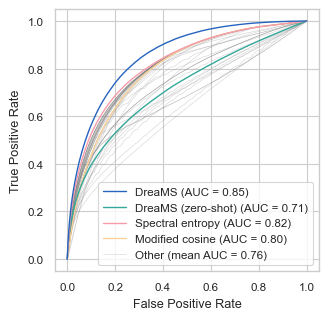

In [20]:
from sklearn import metrics
from tqdm import tqdm
from statistics import mean
from dreams.utils.plots import get_nature_hex_colors, save_fig

colors = get_nature_hex_colors()
plots.init_plotting(figsize=(3.4, 3.4))

methods_renaming = {
    'Entropy distance': 'Spectral entropy',
    'Cosine distance': 'Modified cosine',
    'DreaMS': 'DreaMS',
    'DreaMS (zero-shot)': 'DreaMS (zero-shot)'
}

def zorder(col):
    if col not in special_metrics:
        return 1
    elif col == 'DreaMS':
        return 5
    elif col == 'Entropy distance':
        return 4
    elif col == 'DreaMS (zero-shot)':
        return 3
    else:
        return 2

df_res = df_res[['DreaMS', 'DreaMS (zero-shot)', 'Entropy distance', 'Cosine distance'] + [c for c in df_res.columns if c not in methods_renaming.keys()]]

metric_names = df_res.drop(columns=non_method_cols).columns.tolist()
special_metrics = ['Entropy distance', 'Cosine distance', 'DreaMS', 'DreaMS (zero-shot)']
non_special_metrics = [m for m in metric_names if m not in special_metrics]
label_col = 'inchi14 label'
non_special_aucs = []

special_plot_i = 0
for curve_func in [metrics.roc_curve]:#, metrics.precision_recall_curve]:
    for col in tqdm(metric_names):
        fpr, tpr, thresholds = curve_func(df_res[label_col], df_res[col])
        auc = metrics.auc(fpr, tpr)
        if col in special_metrics:
            plt.plot(fpr, tpr, label=f'{methods_renaming[col]} (AUC = {auc:.2f})' if curve_func == metrics.roc_curve else col, linewidth=1, zorder=zorder(col), color=colors[special_plot_i])
            special_plot_i += 1
        else:
            non_special_aucs.append(auc)
            plt.plot(
                fpr, tpr, color='grey', alpha=0.35, linewidth=0.4,
                label=(f'Other (mean AUC = {mean(non_special_aucs):.2f})' if curve_func == metrics.roc_curve else 'Other metrics') if col == non_special_metrics[-1] else None, zorder=zorder(col)
            )
        # break
    if curve_func == metrics.roc_curve:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    else:
        plt.xlabel('Recall')
        plt.ylabel('Precision')
    plt.legend(markerscale=0.1, loc='lower right')#, bbox_to_anchor=(-0.02, 0.0))
    save_fig(f'spec_retrieval_roc_zero-shot.svg')
    plt.show()

In [78]:
percs = {v: np.percentile(df_res[v], 90) for v in list(spectral_entropy.methods_name.values()) + ['DreaMS']}
percs

{'Entropy distance': 0.8530687462210976,
 'Unweighted entropy distance': 0.8427658675471847,
 'Euclidean distance': 0.8112354850107792,
 'Manhattan distance': 0.6636540204286575,
 'Chebyshev distance': 0.8221106469631195,
 'Squared Euclidean distance': 0.9643679585307836,
 'Fidelity distance': 0.870868808031082,
 'Matusita distance': 0.6406518307755935,
 'Squared-chord distance': 0.8708688795566558,
 'Bhattacharya 1 distance': 0.8929965675222985,
 'Bhattacharya 2 distance': 0.8785308633318681,
 'Harmonic mean distance': 0.8144462943077087,
 'Probabilistic symmetric χ2 distance': 0.8144462957978248,
 'Ruzicka distance': 0.49661843776702874,
 'Roberts distance': 0.5542702317237853,
 'Intersection distance': 0.6636540412902832,
 'Motyka distance': 0.6636540412902832,
 'Canberra distance': 0.1092502874902246,
 'Baroni-Urbani-Buser distance': 0.799728375673294,
 'Penrose size distance': 0.3082026086499741,
 'Mean character distance': 0.979813770163269,
 'Lorentzian distance': 0.611777753415

In [79]:
df_percs = pd.DataFrame()
for k, v in tqdm(percs.items()):
    df_percs[k] = df_res[k].apply(lambda x: x > v).astype(int)
df_percs['sum'] = df_percs.sum(axis=1)
df_percs['label'] = df_res['inchi14 label'].copy()
df_percs

100%|██████████| 45/45 [00:07<00:00,  5.81it/s]


,Entropy distance,Unweighted entropy distance,Euclidean distance,Manhattan distance,Chebyshev distance,Squared Euclidean distance,Fidelity distance,Matusita distance,Squared-chord distance,Bhattacharya 1 distance,...,Inner product distance,Divergence distance,"Avg (L1, L∞) distance",Vicis-Symmetric χ2 3 distance,MSforID distance version 1,MSforID distance,Weighted dot product distance,DreaMS,sum,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,0,1,1,1,35,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
idx = df_percs[(df_percs['DreaMS'] == 1) & (df_percs['sum'] == 1) & (df_percs['label'] == 1)].index.tolist()
len(idx)

2763

402350
SMILES i: CC(C)=CCCC(C)CCO
SMILES j: CC(C)=CCCC(C)CCO
DreaMS percentile: 92.29789416882623
Other methods percentiles: 62.04611013840431 12.861056513755791 84.7454149373447


/Users/roman/miniconda/envs/msml39/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


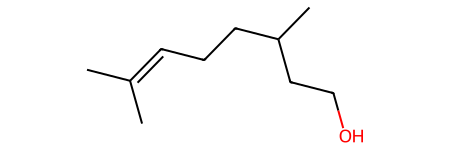

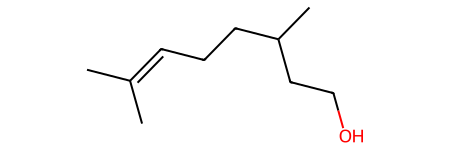

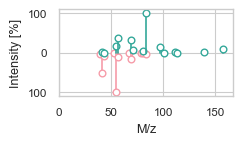

In [19]:
import dreams.utils.spectra as su
for i in [402350]:#pd.Series(idx).sample(n=30, random_state=77): # 123212
    print(i)
    print('SMILES i:', df_res.loc[i]['SMILES i'])
    print('SMILES j:', df_res.loc[i]['SMILES j'])
    res = df_res[[c for c in df_res.columns if c in list(spectral_entropy.methods_name.values()) + ['DreaMS']]].loc[i]
    # display(res)
    methods_percentiles = {k: np.sum(df_res[k] < v) / len(df_res[k]) * 100 for k, v in res.items()}
    other_methods_percentiles = np.array(list({k: v for k, v in methods_percentiles.items() if k != 'DreaMS'}.values()))
    print('DreaMS percentile:', methods_percentiles['DreaMS'])
    print('Other methods percentiles:', other_methods_percentiles.mean(), other_methods_percentiles.std(), other_methods_percentiles.max())
    # display(df_percs[[c for c in df_res.columns if c in list(spectral_entropy.methods_name.values()) + ['DreaMS']]].loc[i])
    display(Chem.MolFromSmiles(df_res.loc[i]['SMILES i']))
    display(Chem.MolFromSmiles(df_res.loc[i]['SMILES j']))
    su.plot_spectrum(df_res.loc[i]['PARSED PEAKS i'], mirror_spec=df_res.loc[i]['PARSED PEAKS j'], colors='nature', figsize=(2.25, 1.125), save_pth=FIGURES / f'spec_retrieval_example.svg')

In [11]:
df_nist = pd.read_pickle(NIST20 / 'nist20_clean_A.pkl')

In [19]:
from tqdm import tqdm
found_idx = []
for i, row in tqdm(df_nist.iterrows(), total=len(df_nist)):
    if (row['PARSED PEAKS'] == df_res.loc[402350]['PARSED PEAKS i']).all() or (row['PARSED PEAKS'] == df_res.loc[402350]['PARSED PEAKS j']).all():
        found_idx.append(i)
    if len(found_idx) == 2:
        break

  3%|▎         | 9032/355219 [00:01<00:57, 6015.57it/s]


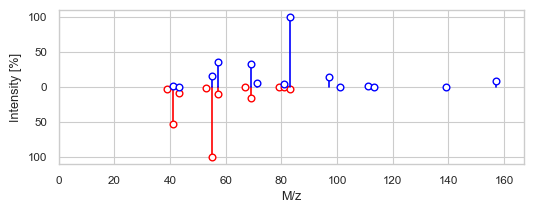

,NAME,NOTES,PRECURSOR TYPE,SPECTRUM TYPE,PRECURSOR M/Z,INSTRUMENT TYPE,INSTRUMENT,SAMPLE INLET,IONIZATION,IN-SOURCE VOLTAGE,...,LINK,PARSED PEAKS,MSnSpectrum,#C,#O,#N,#S,#P,#Cl,#F
8378,.beta.-Citronellol,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,157.1587,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,150,...,NaN,"[[41.04, 43.05, 55.05, 57.07, 69.07, 71.08, 81...",<msml.utils.spectra.MSnSpectrum object at 0x3d...,10,1,0,0,0,0,0
9032,.beta.-Citronellol,Consensus spectrum; Acetonitrile/Water/Formic ...,[M+H]+,MS2,157.1587,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,150,...,NaN,"[[39.02, 41.04, 43.05, 53.04, 55.05, 57.07, 67...",<msml.utils.spectra.MSnSpectrum object at 0x3d...,10,1,0,0,0,0,0


In [27]:
su.plot_spectrum(df_nist.loc[found_idx]['PARSED PEAKS'].iloc[0], mirror_spec=df_nist.loc[found_idx]['PARSED PEAKS'].iloc[1])
df_nist.loc[found_idx]